# Examples

This Jupyter notebook shows some examples for the different functions of the Matlab class `zaf`.

Functions:
- [`stft`](#stft) - Compute the short-time Fourier transform (STFT).
- [`istft`](#istft) - Compute the inverse STFT.
- [`cqtkernel`](#cqtkernel) - Compute the constant-Q transform (CQT) kernel.
- [`cqtspectrogram`](#cqtspectrogram) - Compute the CQT spectrogram using a CQT kernel.
- [`cqtchromagram`](#cqtchromagram) - Compute the CQT chromagram using a CQT kernel.
- [`mfcc`](#mfcc) - Compute the mel frequency cepstrum coefficients (MFCCs).
- [`dct`](#dct) - Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
- [`dst`](#dst) - Compute the discrete sine transform (DST) using the FFT.
- [`mdct`](#mdct) - Compute the modified discrete cosine transform (MDCT) using the FFT.
- [`imdct`](#imdct) - Compute the inverse MDCT using the FFT.

Other:
- `sigplot` - Plot a signal in seconds.
- `specshow` - Display a spectrogram in dB, seconds, and Hz.
- `cqtspecshow` - Display a CQT spectrogram in dB, seconds, and Hz.
- `cqtchromshow` - Display a CQT chromagram in seconds.


Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 12/10/20

## <a id="stft"></a>stft

Compute the short-time Fourier transform (STFT).

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_stft: audio STFT (window_length, number_frames)
```

### Example: Compute and display the spectrogram from an audio file.

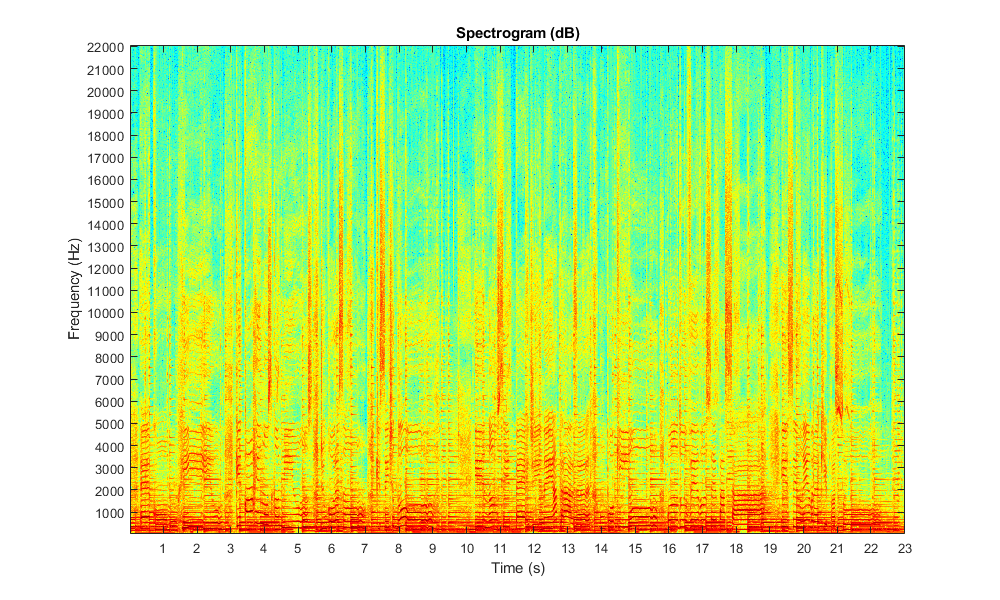

In [16]:
%plot -s 1000,600

% Read the audio signal with its sampling frequency in Hz, and average it over its channels
[audio_signal,sampling_frequency] = audioread('audio_file.wav');
audio_signal = mean(audio_signal,2);

% Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04;

window_length = 2^nextpow2(window_duration*sampling_frequency);

% Compute the window function (periodic Hamming window for COLA)
window_function = hamming(window_length,'periodic');

% Set the step length in samples (half of the window length for COLA)
step_length = window_length/2;

% Compute the STFT
audio_stft = zaf.stft(audio_signal,window_function,step_length);

% Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = abs(audio_stft(2:window_length/2+1,:));

% Display the spectrogram in dB, seconds, and Hz
xtick_step = 1;
ytick_step = 1000;
zaf.specshow(audio_spectrogram, length(audio_signal), sampling_frequency, xtick_step, ytick_step);
title('Spectrogram (dB)')

## <a id="istft"></a>istft

Compute the inverse short-time Fourier transform (STFT).

```
audio_signal = zaf.istft(audio_stft, window_function, step_length)

Inputs:
    audio_stft: audio STFT (window_length, number_frames)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: Estimate the center and the sides from a stereo audio file.

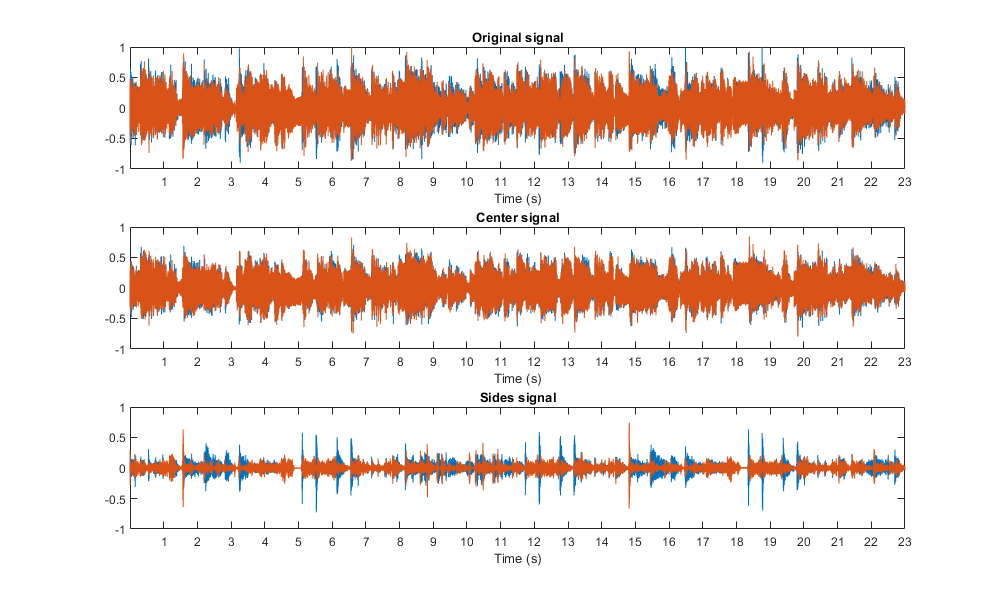

In [18]:
%plot -s 1000,600

% Read the (stereo) audio signal with its sampling frequency in Hz
[audio_signal,sample_rate] = audioread('audio_file.wav');

% Set the parameters for the STFT
window_duration = 0.04;
window_length = 2^nextpow2(window_duration*sample_rate);
window_function = hamming(window_length,'periodic');
step_length = window_length/2;

% Compute the STFTs for the left and right channels
audio_stft1 = zaf.stft(audio_signal(:,1),window_function,step_length);
audio_stft2 = zaf.stft(audio_signal(:,2),window_function,step_length);

% Derive the magnitude spectrograms (with DC component) for the left and right channels
audio_spectrogram1 = abs(audio_stft1(1:window_length/2+1,:));
audio_spectrogram2 = abs(audio_stft2(1:window_length/2+1,:));

% Estimate the time-frequency masks for the left and right channels for the center
center_mask1 = min(audio_spectrogram1,audio_spectrogram2)./audio_spectrogram1;
center_mask2 = min(audio_spectrogram1,audio_spectrogram2)./audio_spectrogram2;

% Derive the STFTs for the left and right channels for the center (with mirrored frequencies)
center_stft1 = [center_mask1;center_mask1(window_length/2:-1:2,:)].*audio_stft1;
center_stft2 = [center_mask2;center_mask2(window_length/2:-1:2,:)].*audio_stft2;

% Synthesize the signals for the left and right channels for the center
center_signal1 = zaf.istft(center_stft1,window_function,step_length);
center_signal2 = zaf.istft(center_stft2,window_function,step_length);

% Derive the final stereo center and sides signals
center_signal = [center_signal1,center_signal2];
center_signal = center_signal(1:length(audio_signal),:);
sides_signal = audio_signal-center_signal;

% Write the center and sides signals
audiowrite('center_signal.wav',center_signal,sample_rate);
audiowrite('sides_signal.wav',sides_signal,sample_rate);

% Display the original, center, and sides signals in seconds
xtick_step = 1;
figure
subplot(3,1,1)
zaf.sigplot(audio_signal, sampling_frequency, xtick_step)
ylim([-1,1]), title("Original signal")
subplot(3,1,2)
zaf.sigplot(center_signal, sampling_frequency, xtick_step)
ylim([-1,1]), title("Center signal")
subplot(3,1,3)
zaf.sigplot(sides_signal, sampling_frequency, xtick_step)
ylim([-1,1]), title("Sides signal")

## <a id="cqtkernel"></a>cqtkernel

Compute the constant-Q transform (CQT) kernel.

```
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

Inputs:
    sampling_frequency: sampling frequency in Hz
    frequency_resolution: frequency resolution in number of frequency channels per semitone
    minimum_frequency: minimum frequency in Hz
    maximum_frequency: maximum frequency in Hz
Output:
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
```

### Example: Compute and display a CQT kernel.

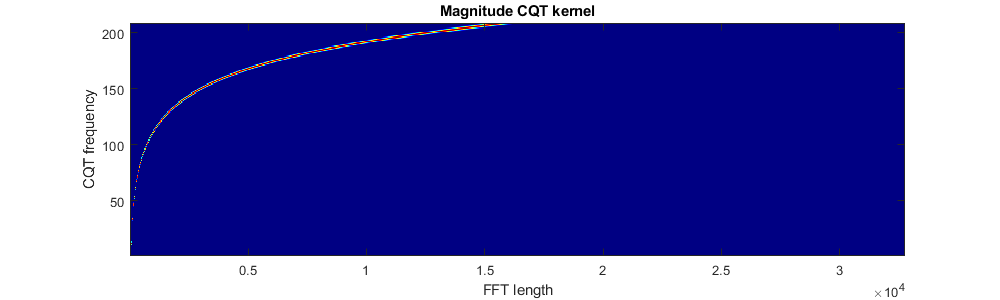

In [17]:
%plot -s 1000,300

% Set the parameters for the CQT kernel
sampling_frequency = 44100;
frequency_resolution = 2;
minimum_frequency = 55;
maximum_frequency = sampling_frequency/2;

% Compute the CQT kernel
cqt_kernel = zaf.cqtkernel(sampling_frequency,frequency_resolution,minimum_frequency,maximum_frequency);

% Display the magnitude CQT kernel
figure
imagesc(abs(cqt_kernel))
axis xy
colormap(jet)
title('Magnitude CQT kernel')
xlabel('FFT length')
ylabel('CQT frequency')

## <a id="cqtspectrogram"></a>cqtspectrogram

Compute the constant-Q transform (CQT) spectrogram using a kernel.

```
audio_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output:
    audio_spectrogram: magnitude audio spectrogram (number_frequencies, number_times)
```

### Example: Compute and display the CQT spectrogram.

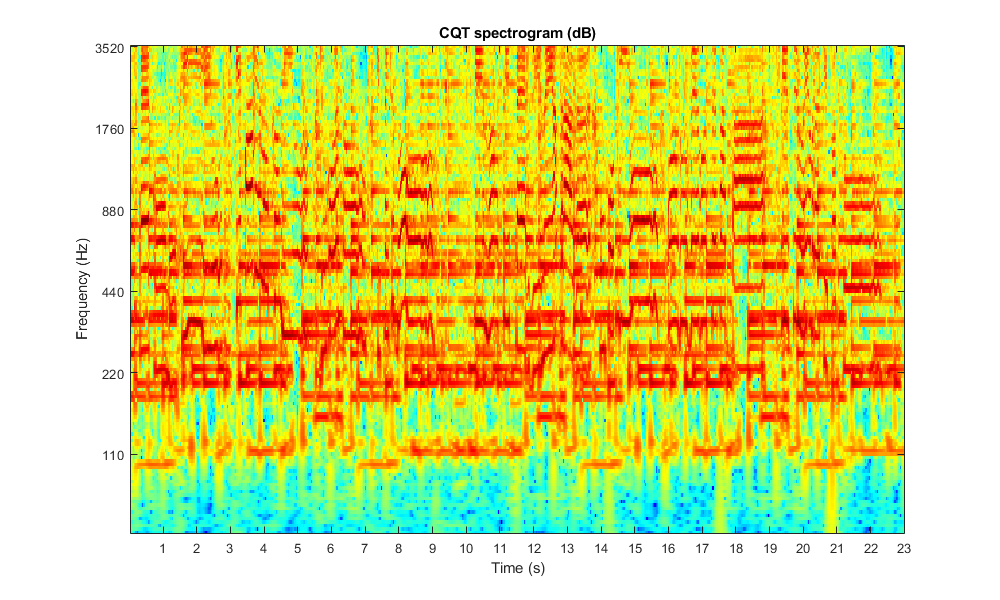

In [20]:
%plot -s 1000,600

% Read the audio signal with its sampling frequency in Hz, and average it over its channels
[audio_signal,sampling_frequency] = audioread('audio_file.wav');
audio_signal = mean(audio_signal,2);

% Compute the CQT kernel using some parameters
frequency_resolution = 2;
minimum_frequency = 55;
maximum_frequency = 3520;
cqt_kernel = zaf.cqtkernel(sampling_frequency,frequency_resolution,minimum_frequency,maximum_frequency);

% Compute the (magnitude) CQT spectrogram using the kernel
time_resolution = 25;
audio_spectrogram = zaf.cqtspectrogram(audio_signal,sampling_frequency,time_resolution,cqt_kernel);

% Display the CQT spectrogram in dB, seconds, and Hz
xtick_step = 1;
zaf.cqtspecshow(audio_spectrogram,time_resolution, frequency_resolution,minimum_frequency,xtick_step);
title('CQT spectrogram (dB)')

## <a id="cqtchromagram"></a>cqtchromagram

Compute the constant-Q transform (CQT) chromagram using a kernel.

```
audio_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    frequency_resolution: frequency resolution in number of frequency channels per semitones
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output:
    audio_chromagram: audio chromagram (number_chromas, number_times)
```

### Example: Compute and display the CQT chromagram.

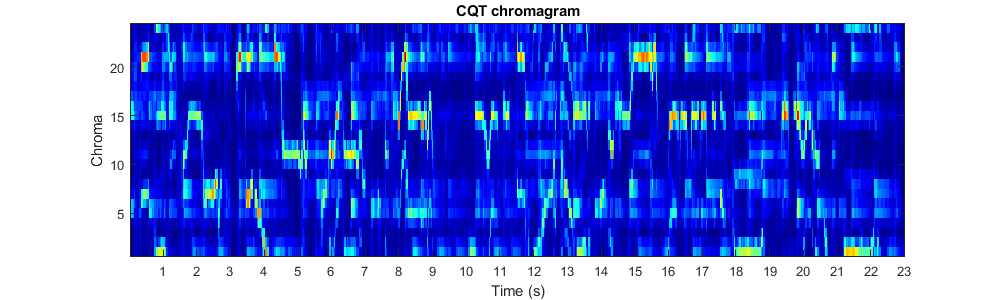

In [23]:
%plot -s 1000,300

% Read the audio signal with its sampling frequency in Hz, and average it over its channels
[audio_signal,sampling_frequency] = audioread('audio_file.wav');
audio_signal = mean(audio_signal,2);

% Compute the CQT kernel using some parameters
frequency_resolution = 2;
minimum_frequency = 55;
maximum_frequency = 3520;
cqt_kernel = zaf.cqtkernel(sampling_frequency,frequency_resolution,minimum_frequency,maximum_frequency);

% Compute the CQT chromagram
time_resolution = 25;
audio_chromagram = zaf.cqtchromagram(audio_signal,sampling_frequency,time_resolution,frequency_resolution,cqt_kernel);

% Display the CQT chromagram in seconds
xtick_step = 1;
zaf.cqtchromshow(audio_chromagram, time_resolution, xtick_step)
title('CQT chromagram')

## <a id="mfcc"></a>mfcc

Compute the mel frequency cepstrum coefficients (MFFCs).

```
audio_mfcc = zaf.mfcc(audio_signal, sampling_frequency, number_filters, number_coefficients)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    number_filters: number of filters
    number_coefficients: number of coefficients (without the 0th coefficient)
Output:
    audio_mfcc: audio MFCCs (number_times, number_coefficients)
```

### Example: Compute and display the MFCCs, delta MFCCs, and delta-detla MFCCs.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



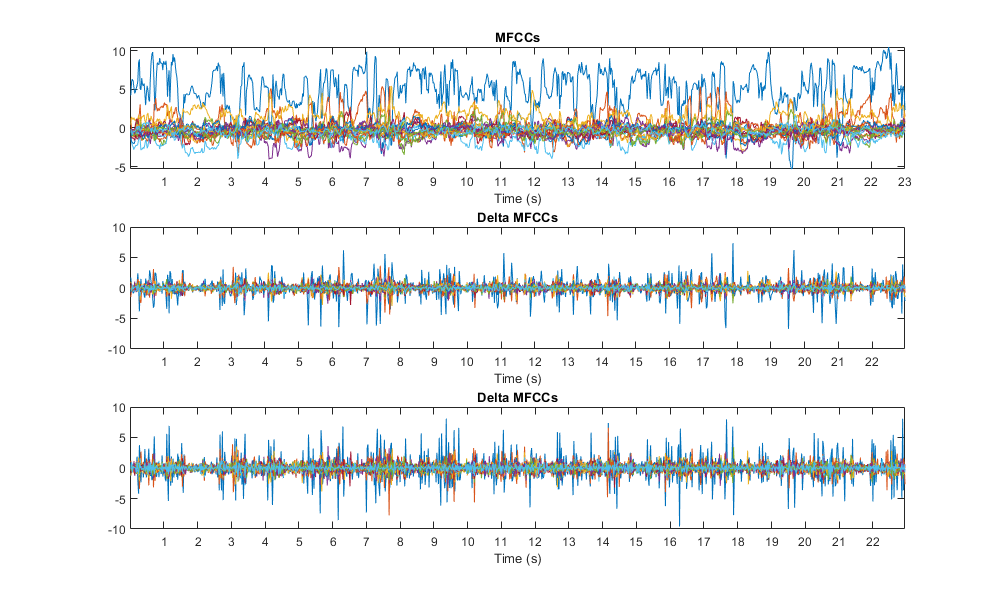

In [5]:
%plot -s 1000,600

% Read the audio signal with its sampling frequency in Hz, and average it over its channels
[audio_signal,sampling_frequency] = audioread('audio_file.wav')
audio_signal = mean(audio_signal,2);

% Compute the MFCCs with a given number of filters and coefficients
number_filters = 40;
number_coefficients = 20;
audio_mfcc = zaf.mfcc(audio_signal,sampling_frequency,number_filters,number_coefficients);

% Compute the delta and delta-delta MFCCs
audio_dmfcc = diff(audio_mfcc,1,2);
audio_ddmfcc = diff(audio_dmfcc,1,2);

% Compute the time resolution for the MFCCs in number of time frames per second (~ sampling frequency for the MFCCs)
time_resolution = sampling_frequency*size(audio_mfcc,2)/length(audio_signal);

% Display the MFCCs, delta MFCCs, and delta-delta MFCCs in seconds
xtick_step = 1;
subplot(3,1,1)
zaf.sigplot(audio_mfcc',time_resolution,xtick_step), title('MFCCs')
subplot(3,1,2)
zaf.sigplot(audio_dmfcc',time_resolution,xtick_step), title('Delta MFCCs')
subplot(3,1,3)
zaf.sigplot(audio_ddmfcc',time_resolution,xtick_step), title('Delta MFCCs')